___

<a href='http://www.pieriandata.com'> <img src='../Pierian_Data_Logo.png' /></a>
___

# Scikit-learn Primer

**Scikit-learn** (http://scikit-learn.org/) is an open-source machine learning library for Python that offers a variety of regression, classification and clustering algorithms.

In this section we'll perform a fairly simple classification exercise with scikit-learn. In the next section we'll leverage the machine learning strength of scikit-learn to perform natural language classifications.

# Installation and Setup

### From the command line or terminal:
> `conda install scikit-learn`
> <br>*or*<br>
> `pip install -U scikit-learn`

Scikit-learn additionally requires that NumPy and SciPy be installed. For more info visit http://scikit-learn.org/stable/install.html

# Perform Imports and Load Data
For this exercise we'll be using the **SMSSpamCollection** dataset from [UCI datasets](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection) that contains more than 5 thousand SMS phone messages.<br>You can check out the [**sms_readme**](../TextFiles/sms_readme.txt) file for more info.

The file is a [tab-separated-values](https://en.wikipedia.org/wiki/Tab-separated_values) (tsv) file with four columns:
> **label** - every message is labeled as either ***ham*** or ***spam***<br>
> **message** - the message itself<br>
> **length** - the number of characters in each message<br>
> **punct** - the number of punctuation characters in each message

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('../TextFiles/smsspamcollection.tsv', sep='\t')
df.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


In [2]:
len(df)

5572

## Check for missing values:
Machine learning models usually require complete data.

In [3]:
df.isnull().sum()

label      0
message    0
length     0
punct      0
dtype: int64

## Take a quick look at the *ham* and *spam* `label` column:

In [4]:
df['label'].unique()

array(['ham', 'spam'], dtype=object)

In [5]:
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

<font color=green>We see that 4825 out of 5572 messages, or 86.6%, are ham.<br>This means that any machine learning model we create has to perform **better than 86.6%** to beat random chance.</font>

## Visualize the data:
Since we're not ready to do anything with the message text, let's see if we can predict ham/spam labels based on message length and punctuation counts. We'll look at message `length` first:

In [6]:
df['length'].describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

<font color=green>This dataset is extremely skewed. The mean value is 80.5 and yet the max length is 910. Let's plot this on a logarithmic x-axis.</font>

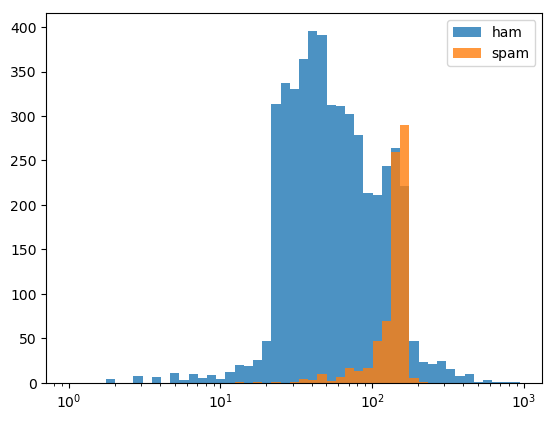

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.xscale('log')
bins = 1.15 ** (np.arange(0, 50))
plt.hist(df[df['label']=='ham']['length'], bins=bins, alpha=0.8)
plt.hist(df[df['label']=='spam']['length'], bins=bins, alpha=0.8)
plt.legend(('ham','spam'))
plt.show()

<font color=green>It looks like there's a small range of values where a message is more likely to be spam than ham.</font>

Now let's look at the `punct` column:

In [8]:
df['punct'].describe()

count    5572.000000
mean        4.177495
std         4.623919
min         0.000000
25%         2.000000
50%         3.000000
75%         6.000000
max       133.000000
Name: punct, dtype: float64

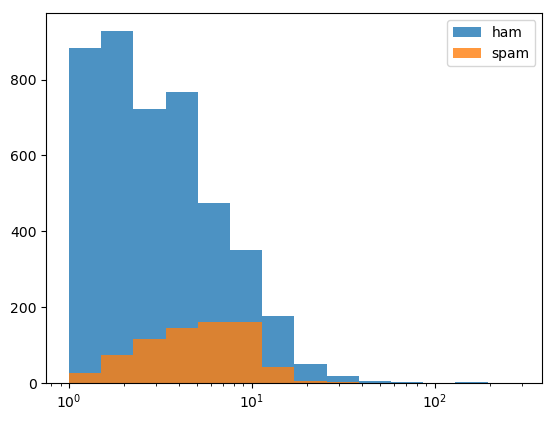

In [9]:
plt.xscale('log')
bins = 1.5 ** (np.arange(0, 15))
plt.hist(df[df['label']=='ham']['punct'], bins=bins, alpha=0.8)
plt.hist(df[df['label']=='spam']['punct'], bins=bins, alpha=0.8)
plt.legend(('ham','spam'))
plt.show()

<font color=green>This looks even worse - there seem to be no values where one would pick spam over ham. We'll still try to build a machine learning classification model, but we should expect poor results.</font>

___
# Split the data into train & test sets:

If we wanted to divide the DataFrame into two smaller sets, we could use
> `train, test = train_test_split(df)`

For our purposes let's also set up our Features (X) and Labels (y). The Label is simple - we're trying to predict the `label` column in our data. For Features we'll use the `length` and `punct` columns. *By convention, **X** is capitalized and **y** is lowercase.*

## Selecting features
There are two ways to build a feature set from the columns we want. If the number of features is small, then we can pass those in directly:
> `X = df[['length','punct']]`

If the number of features is large, then it may be easier to drop the Label and any other unwanted columns:
> `X = df.drop(['label','message'], axis=1)`

These operations make copies of **df**, but do not change the original DataFrame in place. All the original data is preserved.

In [10]:
# Create Feature and Label sets
X = df[['length','punct']]  # note the double set of brackets
y = df['label']

## Additional train/test/split arguments:
The default test size for `train_test_split` is 30%. Here we'll assign 33% of the data for testing.<br>
Also, we can set a `random_state` seed value to ensure that everyone uses the same "random" training & testing sets.

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print('Training Data Shape:', X_train.shape)
print('Testing Data Shape: ', X_test.shape)

/home/shlomi/anaconda3/envs/nlp_course/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


Training Data Shape: (3733, 2)
Testing Data Shape:  (1839, 2)


Now we can pass these sets into a series of different training & testing algorithms and compare their results.

___
# Train a Logistic Regression classifier
One of the simplest multi-class classification tools is [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Scikit-learn offers a variety of algorithmic solvers; we'll use [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS). 

In [12]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(solver='lbfgs')

lr_model.fit(X_train, y_train)

/home/shlomi/anaconda3/envs/nlp_course/lib/python3.7/site-packages/sklearn/utils/fixes.py:357: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

## Test the Accuracy of the Model

In [13]:
from sklearn import metrics

# Create a prediction set:
predictions = lr_model.predict(X_test)

# Print a confusion matrix
print(metrics.confusion_matrix(y_test,predictions))

[[1547   46]
 [ 241    5]]


In [14]:
# You can make the confusion matrix less confusing by adding labels:
df = pd.DataFrame(metrics.confusion_matrix(y_test,predictions), index=['ham','spam'], columns=['ham','spam'])
df

,ham,spam
ham,1547,46
spam,241,5


<font color=green>These results are terrible! More spam messages were confused as ham (241) than correctly identified as spam (5), although a relatively small number of ham messages (46) were confused as spam.</font>

In [15]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

         ham       0.87      0.97      0.92      1593
        spam       0.10      0.02      0.03       246

   micro avg       0.84      0.84      0.84      1839
   macro avg       0.48      0.50      0.47      1839
weighted avg       0.76      0.84      0.80      1839



In [16]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

0.843936922240348


<font color=green>This model performed *worse* than a classifier that assigned all messages as "ham" would have!</font>

___
# Train a naïve Bayes classifier:
One of the most common - and successful - classifiers is [naïve Bayes](http://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes).

In [17]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()

nb_model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Run predictions and report on metrics

In [18]:
predictions = nb_model.predict(X_test)
print(metrics.confusion_matrix(y_test,predictions))

[[1583   10]
 [ 246    0]]


<font color=green>The total number of confusions dropped from **287** to **256**. [241+46=287, 246+10=256]</font>

In [19]:
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

         ham       0.87      0.99      0.93      1593
        spam       0.00      0.00      0.00       246

   micro avg       0.86      0.86      0.86      1839
   macro avg       0.43      0.50      0.46      1839
weighted avg       0.75      0.86      0.80      1839



In [20]:
print(metrics.accuracy_score(y_test,predictions))

0.8607939097335509


<font color=green>Better, but still less accurate than 86.6%</font>

___
# Train a support vector machine (SVM) classifier
Among the SVM options available, we'll use [C-Support Vector Classification (SVC)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

In [21]:
from sklearn.svm import SVC
svc_model = SVC(gamma='auto')
svc_model.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Run predictions and report on metrics

In [22]:
predictions = svc_model.predict(X_test)
print(metrics.confusion_matrix(y_test,predictions))

[[1515   78]
 [ 131  115]]


<font color=green>The total number of confusions dropped even further to **209**.</font>

In [23]:
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

         ham       0.92      0.95      0.94      1593
        spam       0.60      0.47      0.52       246

   micro avg       0.89      0.89      0.89      1839
   macro avg       0.76      0.71      0.73      1839
weighted avg       0.88      0.89      0.88      1839



In [24]:
print(metrics.accuracy_score(y_test,predictions))

0.8863512778684067


<font color=green>And finally we have a model that performs *slightly* better than random chance.</font>

Great! Now you should be able to load a dataset, divide it into training and testing sets, and perform simple analyses using scikit-learn.
## Next up: Feature Extraction from Text